<a href="https://colab.research.google.com/github/Marwa-Chouhdary/Data-Science-Projects/blob/main/Sales_Forecasting_for_a_Retail_Chain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales Forecasting for a Retail Chain

In [5]:
!pip install prophet

In [6]:
from prophet import Prophet

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

##Load Dataset

In [8]:
features = pd.read_csv('Features data set.csv')
sales = pd.read_csv('sales data-set.csv')
stores = pd.read_csv('stores data-set.csv')

#Merge Datasets

In [9]:
df = pd.merge(sales, features, on=["Store", "Date", "IsHoliday"], how="left")
df = pd.merge(df, stores, on="Store", how="left")

#Clean Data

In [10]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')

#Check for missing values, duplicates, outliers

In [11]:
print("Missing Values:\n", df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
outliers = (np.abs(df[numeric_cols].apply(zscore)) > 3).sum()
print("\nOutliers per column:\n", outliers)

Missing Values:
 Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

Duplicate Rows: 0

Outliers per column:
 Store               0
Dept                0
Weekly_Sales     8848
Temperature        69
Fuel_Price          0
MarkDown1           0
MarkDown2           0
MarkDown3           0
MarkDown4           0
MarkDown5           0
CPI                 0
Unemployment    13756
Size                0
dtype: int64


#Check Granularity

In [12]:
granularity = df.groupby(["Store", "Dept", "Date"]).size().value_counts()
print("\nData Granularity:\n", granularity.head())


Data Granularity:
 1    421570
Name: count, dtype: int64


#Feature Engineering

In [13]:
df["Week"] = df["Date"].dt.isocalendar().week
df["Month"] = df["Date"].dt.month

#Preprocessing

In [14]:
# Create Year and Week features
df['Year'] = df['Date'].dt.year
df['Week'] = df['Date'].dt.isocalendar().week

In [15]:
# Interpolate numeric columns (time-based)
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].interpolate(method='linear', limit_direction='forward')

In [16]:
# Forward fill any remaining nulls (just in case)
df.fillna(method='ffill', inplace=True)

##Handle Categorical Features

In [17]:
# Encode 'Type' (Store Type) if it exists
if 'Type' in df.columns:
    le = LabelEncoder()
    df['Type_encoded'] = le.fit_transform(df['Type'])

##Aggregate Sales per Week per Store (Optional if needed)

In [18]:
# If you want to forecast at a higher level (e.g. store level weekly)
df_weekly = df.groupby(['Store', 'Date']).agg({
    'Weekly_Sales': 'sum',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean',
    'Size': 'first',
    'IsHoliday': 'first',
    'Type_encoded': 'first' if 'Type_encoded' in df else 'first'
}).reset_index()

##Normalize/Scale Features

In [19]:
features_to_scale = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']
scaler = StandardScaler()
df_weekly[features_to_scale] = scaler.fit_transform(df_weekly[features_to_scale])

##Tag Holidays or Special Events

In [20]:
# Already present: IsHoliday column
# You can visualize or use it directly in modeling
# Optional: Add a custom tag if needed (e.g., Christmas week, Thanksgiving week)
df_weekly['Holiday_Tag'] = df_weekly['IsHoliday'].apply(lambda x: 'Holiday' if x else 'Non-Holiday')


##Final Feature Engineering

In [21]:
# Add date-based features
df_weekly['Date'] = pd.to_datetime(df_weekly['Date'])
df_weekly['Week'] = df_weekly['Date'].dt.isocalendar().week
df_weekly['Month'] = df_weekly['Date'].dt.month
df_weekly['Year'] = df_weekly['Date'].dt.year

# Final check
df_weekly.head()

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size,IsHoliday,Type_encoded,Holiday_Tag,Week,Month,Year
0,1,2010-02-05,1643690.90,-0.995136,-1.713800,1.004175,0.056964,0.333175,False,0,Non-Holiday,5,2,2010
1,1,2010-02-12,1641957.44,-1.201170,-1.766089,1.007880,0.056964,0.333175,True,0,Holiday,6,2,2010
2,1,2010-02-19,1611968.17,-1.124178,-1.840166,1.009074,0.056964,0.333175,False,0,Non-Holiday,7,2,2010
3,1,2010-02-26,1409727.59,-0.760907,-1.737766,1.009849,0.056964,0.333175,False,0,Non-Holiday,8,2,2010
4,1,2010-03-05,1554806.68,-0.767955,-1.598328,1.010624,0.056964,0.333175,False,0,Non-Holiday,9,3,2010


#Visualization

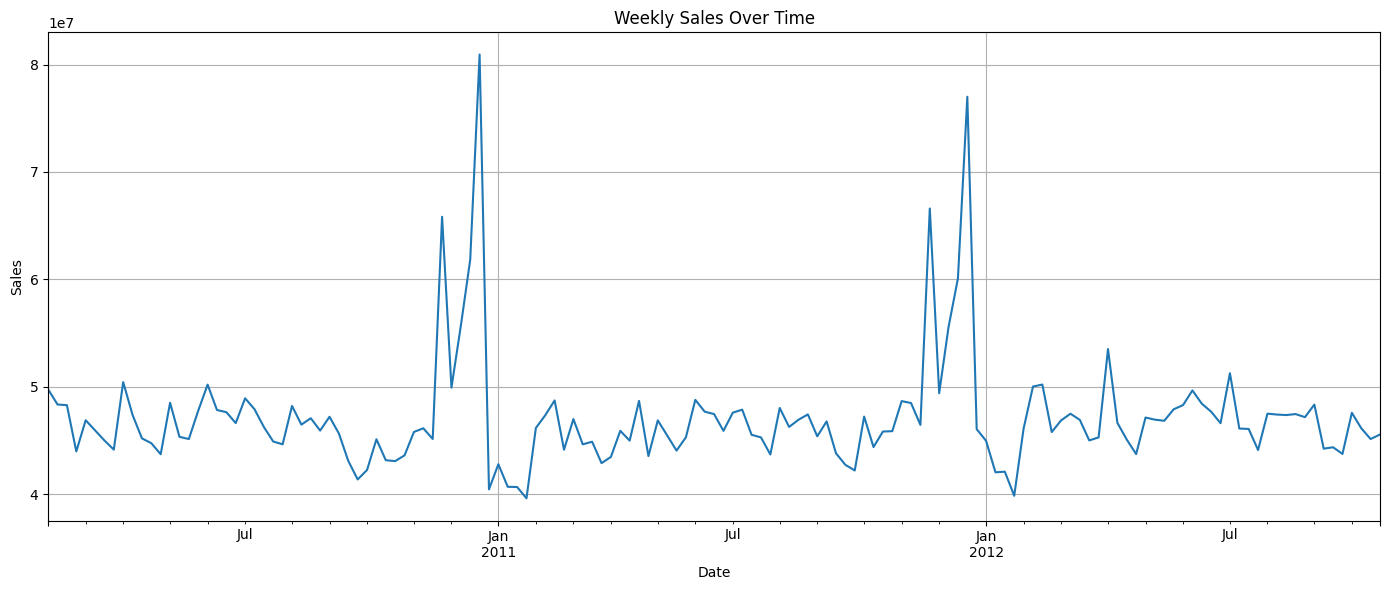

In [22]:
# Sales trend over time
plt.figure(figsize=(14, 6))
df.groupby("Date")["Weekly_Sales"].sum().plot()
plt.title("Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

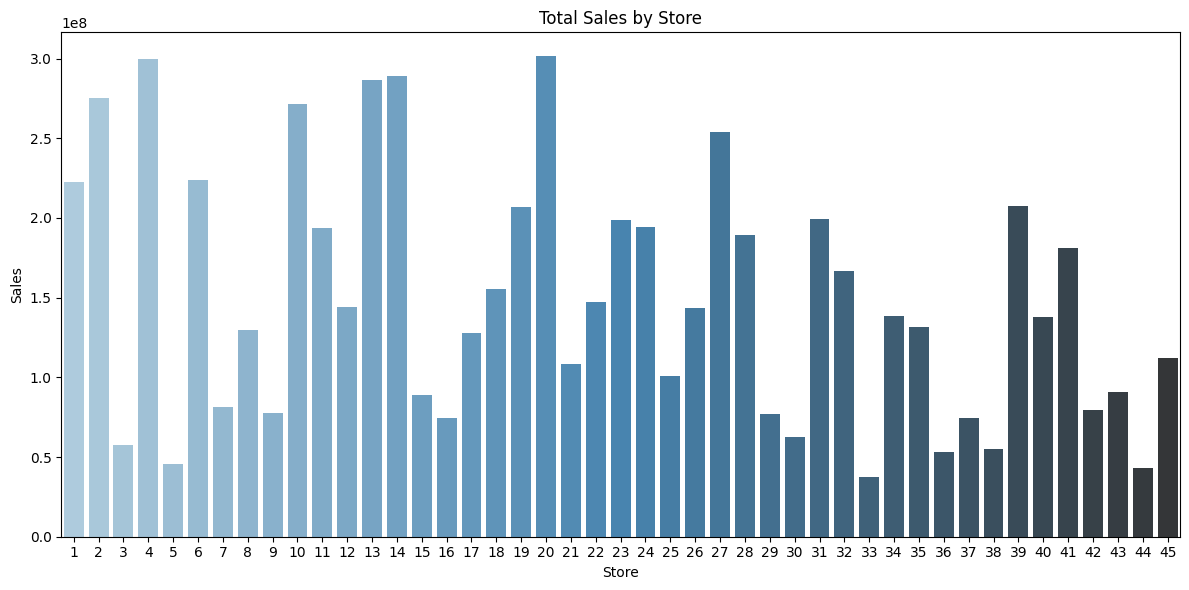

In [23]:
# Sales by Store
plt.figure(figsize=(12, 6))
store_sales = df.groupby("Store")["Weekly_Sales"].sum()
sns.barplot(x=store_sales.index, y=store_sales.values, palette="Blues_d")
plt.title("Total Sales by Store")
plt.xlabel("Store")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

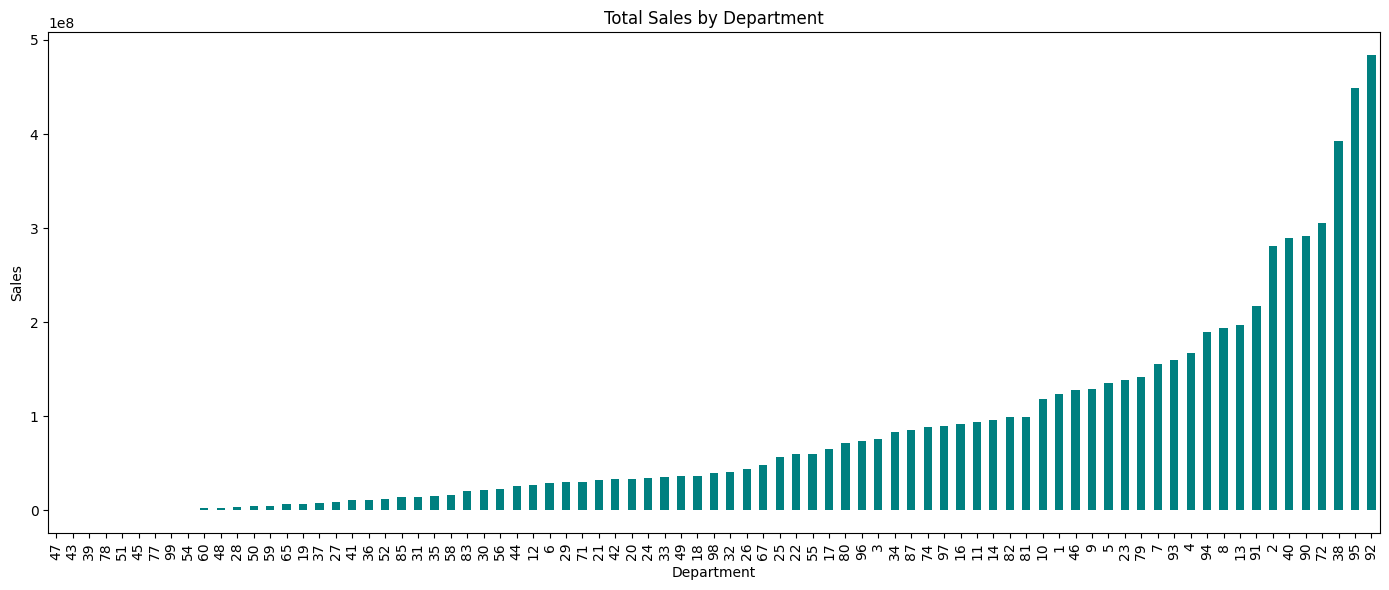

In [24]:
# Sales by Department
plt.figure(figsize=(14, 6))
dept_sales = df.groupby("Dept")["Weekly_Sales"].sum().sort_values()
dept_sales.plot(kind="bar", color="teal")
plt.title("Total Sales by Department")
plt.xlabel("Department")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

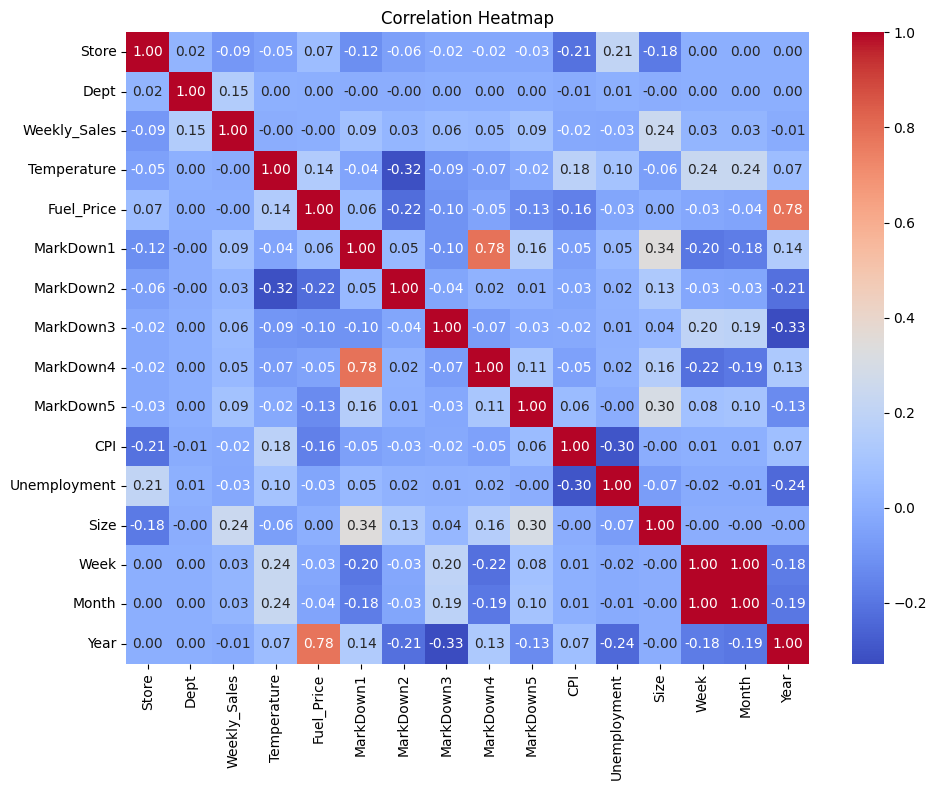

In [25]:
# Heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

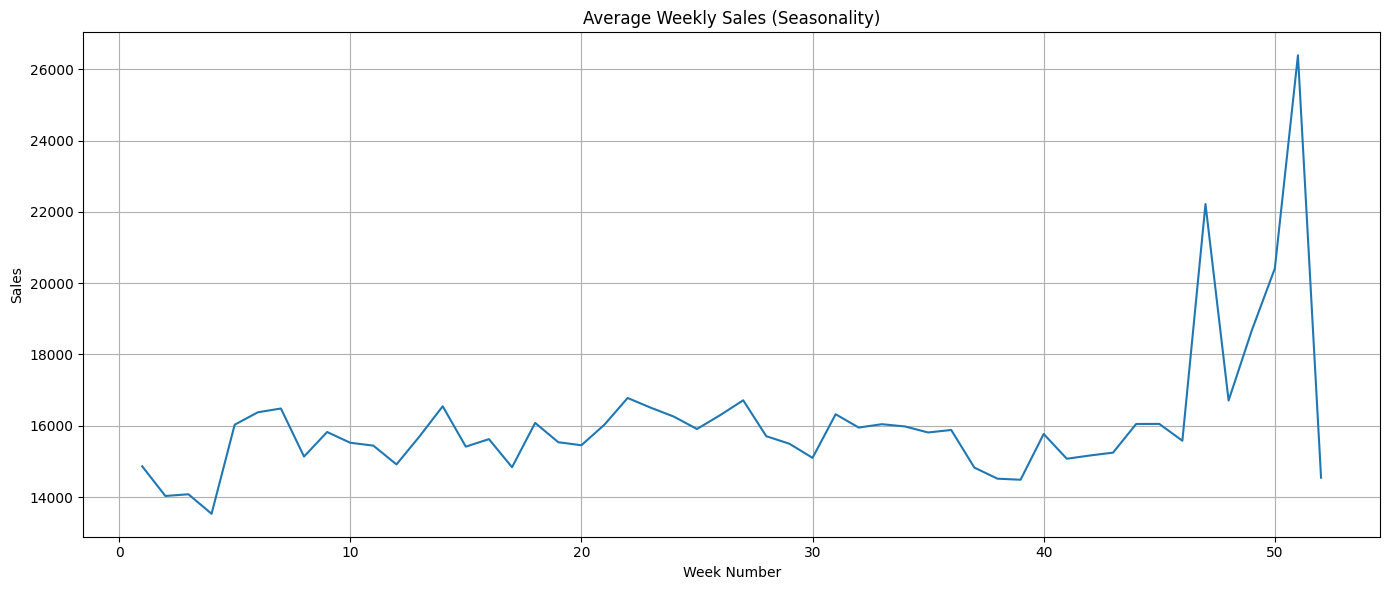

In [26]:
# Weekly Seasonality
plt.figure(figsize=(14, 6))
weekly_avg = df.groupby("Week")["Weekly_Sales"].mean()
sns.lineplot(x=weekly_avg.index, y=weekly_avg.values)
plt.title("Average Weekly Sales (Seasonality)")
plt.xlabel("Week Number")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

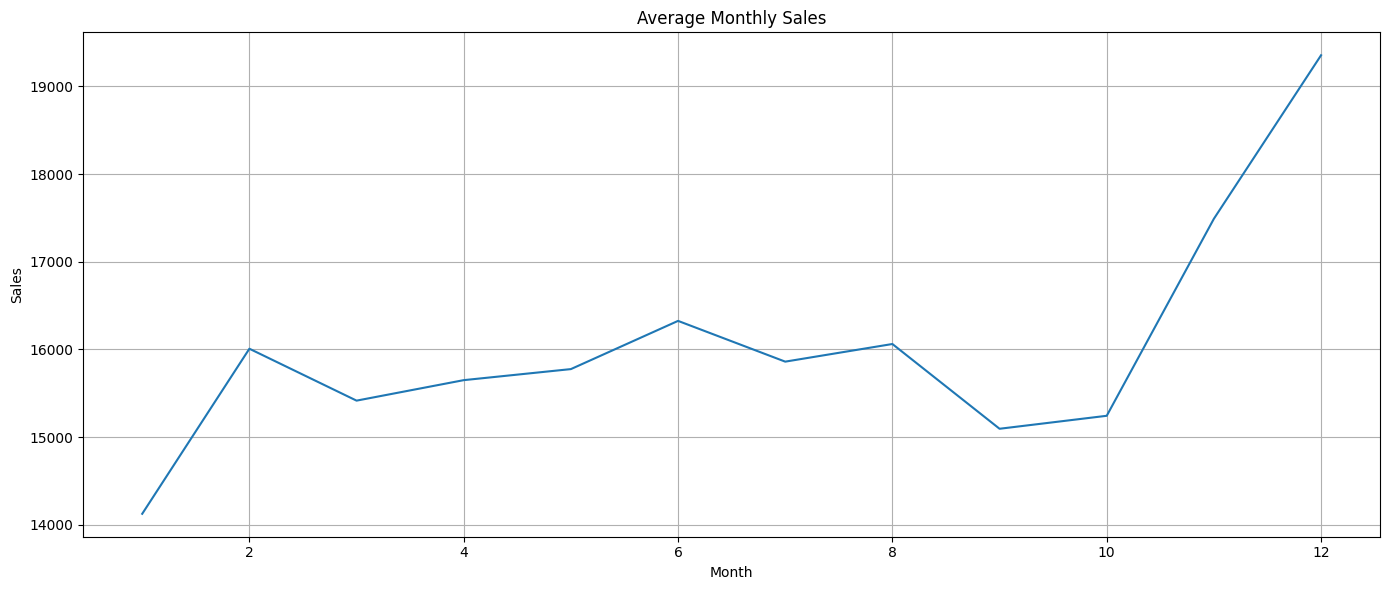

In [27]:
# Monthly Seasonality
plt.figure(figsize=(14, 6))
monthly_avg = df.groupby("Month")["Weekly_Sales"].mean()
sns.lineplot(x=monthly_avg.index, y=monthly_avg.values)
plt.title("Average Monthly Sales")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

#A. Time Series Forecasting (Store Level)

##TIME SERIES FORECASTING WITH PROPHET

In [28]:
from prophet import Prophet

In [29]:
# Filter data for a specific store and department
store_id = 1
dept_id = 1
df_store = df[(df['Store'] == store_id) & (df['Dept'] == dept_id)]

In [30]:
# Aggregate weekly sales
df_ts = df_store.groupby("Date")["Weekly_Sales"].sum().reset_index()
df_ts.columns = ["ds", "y"]

In [31]:
# Train/test split: last 12 weeks for testing
train = df_ts.iloc[:-12]
test = df_ts.iloc[-12:]

In [32]:
# Build and fit model
model = Prophet()
model.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnrqqnked/9c1frjtv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnrqqnked/xikqvt3b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17711', 'data', 'file=/tmp/tmpnrqqnked/9c1frjtv.json', 'init=/tmp/tmpnrqqnked/xikqvt3b.json', 'output', 'file=/tmp/tmpnrqqnked/prophet_modelhm1xaics/prophet_model-20250719095235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:52:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:52:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [33]:
# Forecast
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)

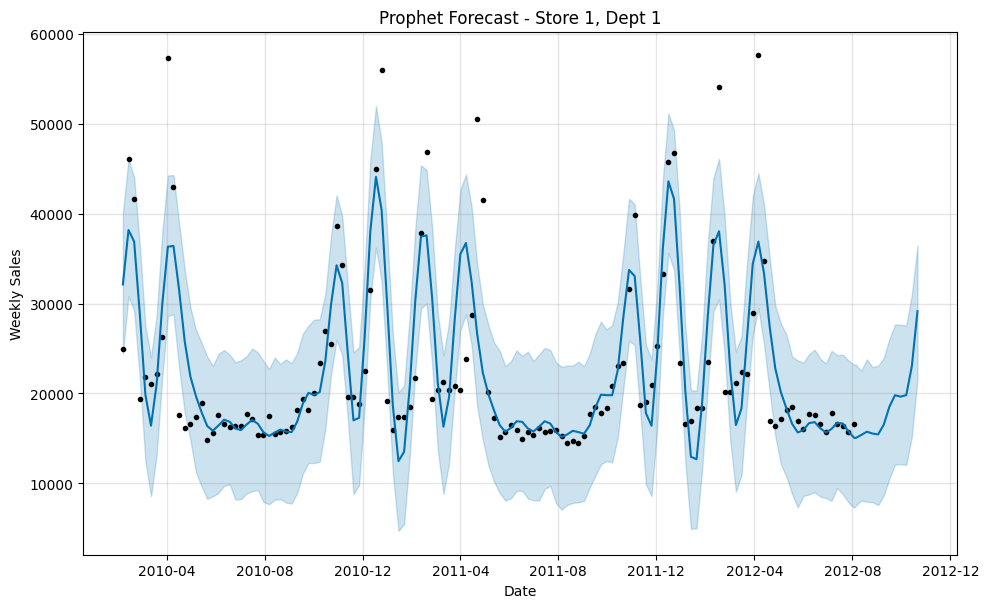

In [34]:
# Plot forecast
model.plot(forecast)
plt.title(f"Prophet Forecast - Store {store_id}, Dept {dept_id}")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.grid(True)
plt.show()

#B. Regression Modeling (Multi-store, Multi-feature)

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [42]:
# Feature selection
features = ["Temperature", "Fuel_Price", "MarkDown1", "MarkDown2", "MarkDown3",
            "MarkDown4", "MarkDown5", "CPI", "Unemployment", "Size"]
df_reg = df.dropna(subset=features + ["Weekly_Sales"])

X = df_reg[features]
y = df_reg["Weekly_Sales"]

In [37]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [45]:
# --- LINEAR REGRESSION ---
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print("Linear Regression:")
print("MAE:", mean_absolute_error(y_test, lr_pred))
rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
print("RMSE:", rmse)
print("R²:", r2_score(y_test, lr_pred))

Linear Regression:
MAE: 14390.028662885581
RMSE: 21135.427149308605
R²: 0.0635936722949827


In [46]:
# --- RANDOM FOREST ---
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("\nRandom Forest:")
print("MAE:", mean_absolute_error(y_test, rf_pred))
rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
print("RMSE:", rmse)
print("R²:", r2_score(y_test, rf_pred))


Random Forest:
MAE: 14735.888971497066
RMSE: 21208.29411417193
R²: 0.057125791854835795


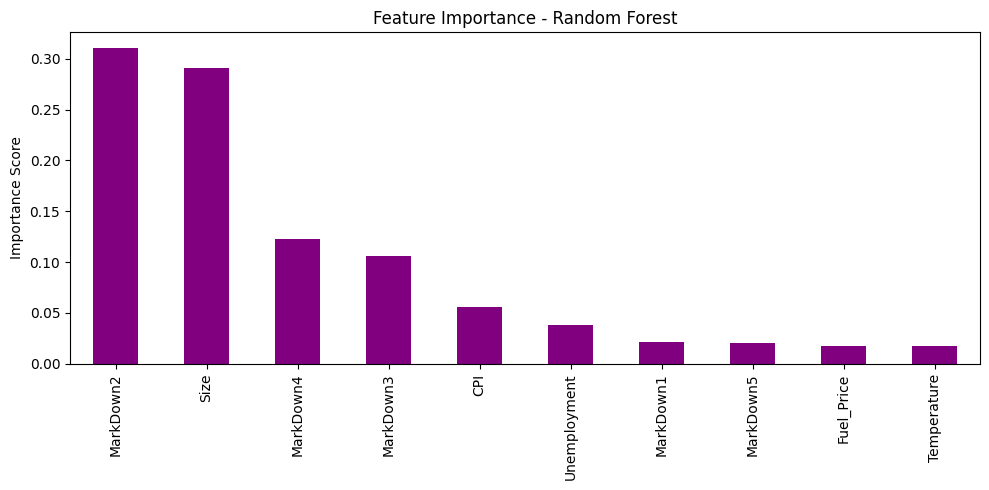

In [47]:
# --- Feature Importance ---
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
importances.plot(kind='bar', color='purple')
plt.title("Feature Importance - Random Forest")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

##Plot actual vs predicted

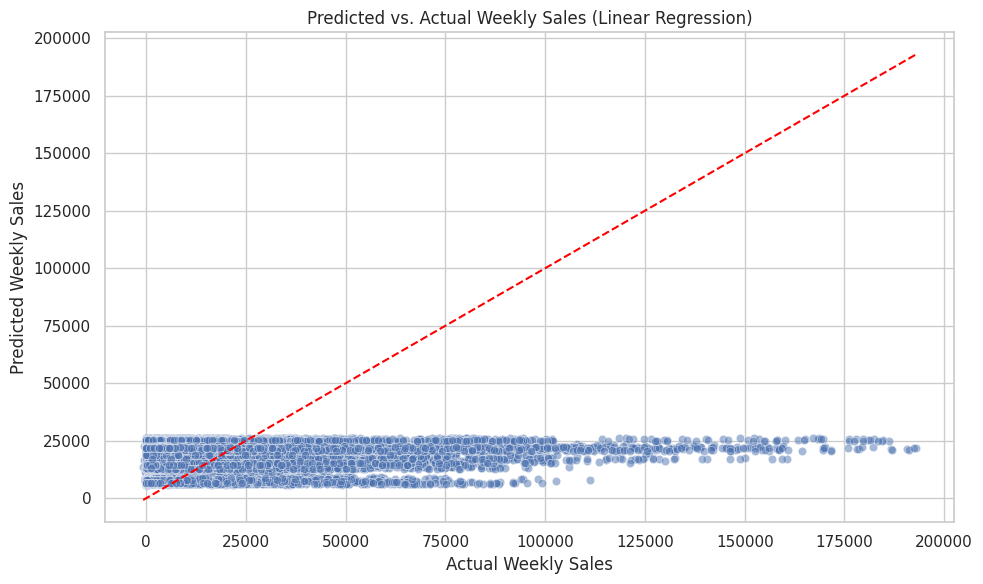

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=lr_pred, alpha=0.5)

# Add diagonal line for perfect prediction
max_val = max(y_test.max(), max(lr_pred))
min_val = min(y_test.min(), min(lr_pred))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red')

plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Predicted vs. Actual Weekly Sales (Linear Regression)")
plt.tight_layout()
plt.show()
